Alle verfügbaren Methoden: ['NeuralNet', 'RandomForest', 'lasso']
Ausgeschlossene Methoden: {'nimoNew', 'nimo_baseline', 'lassonet', 'nimo_variant', 'NeuralNet2'}
Verwendete Methoden: ['NeuralNet', 'RandomForest', 'lasso']


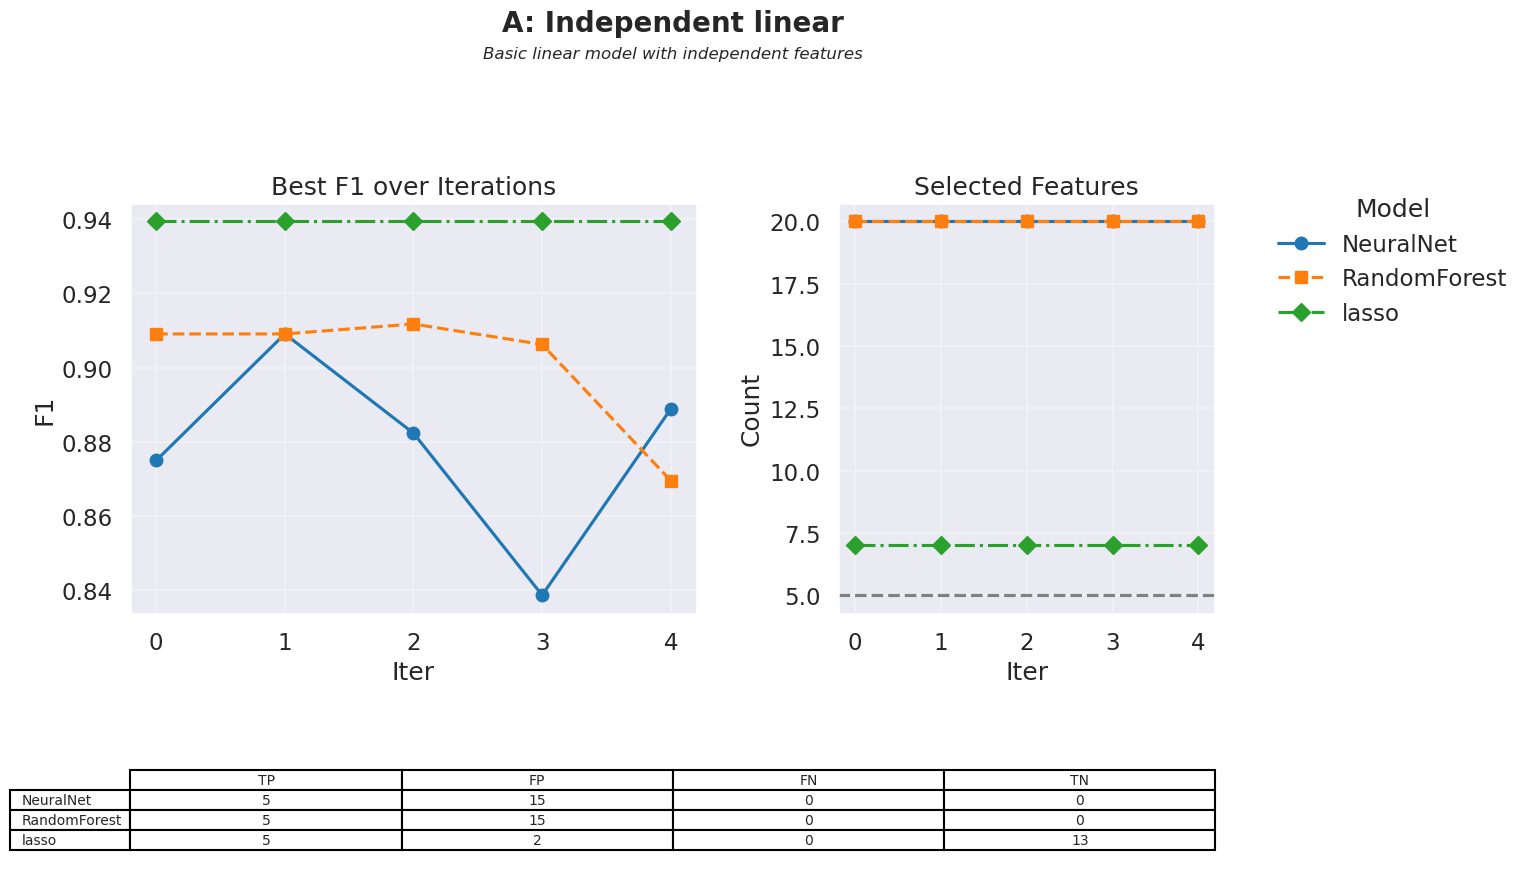

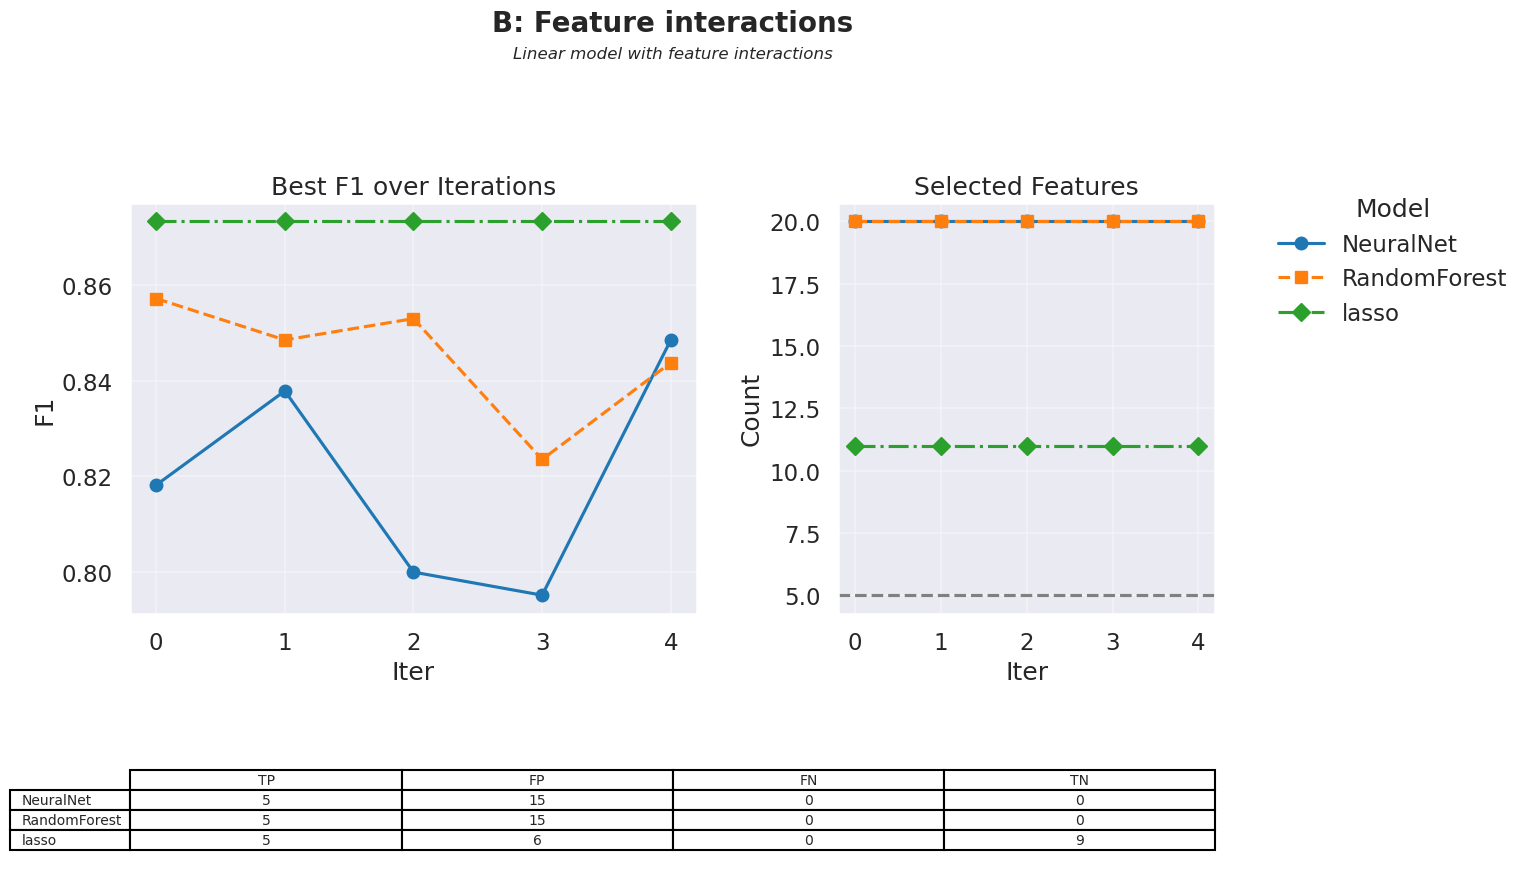

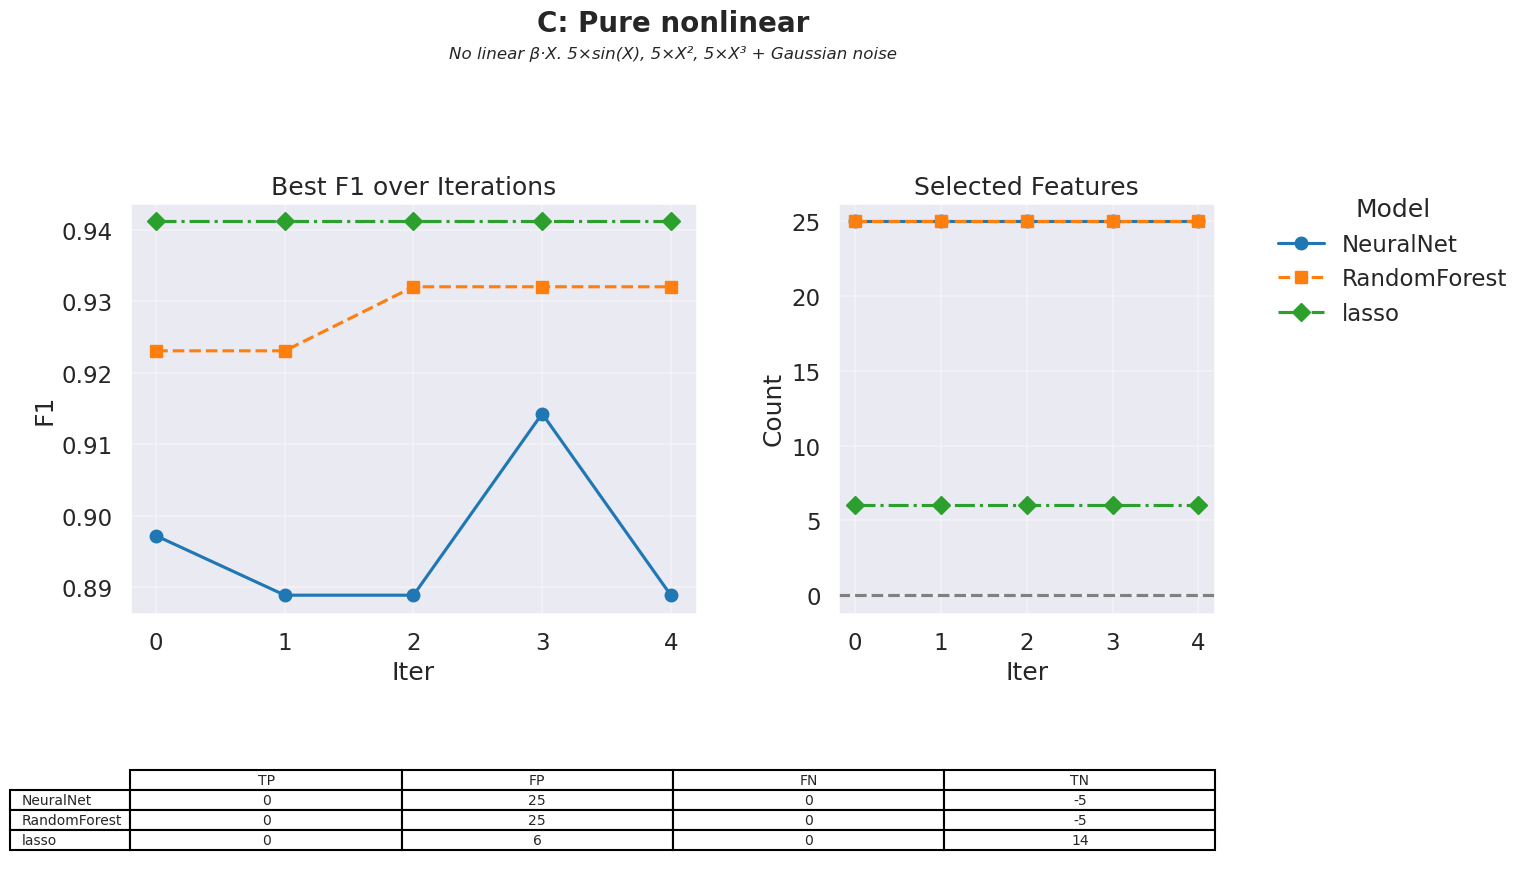

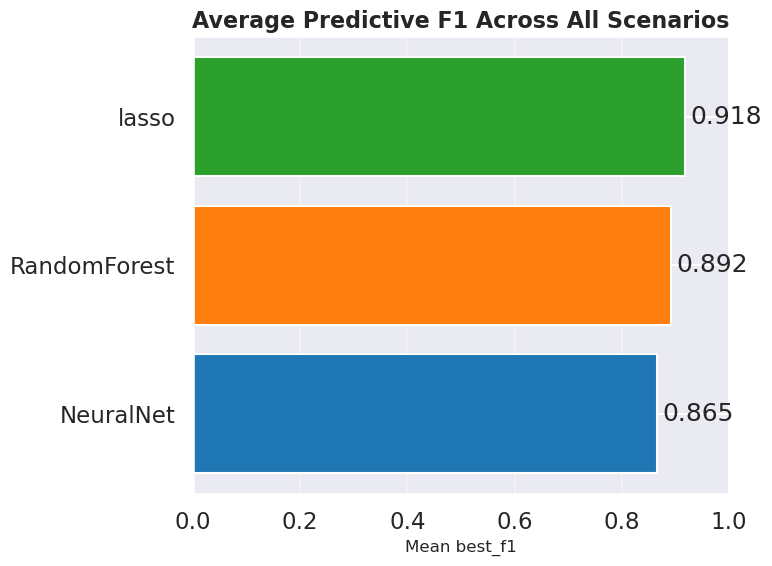

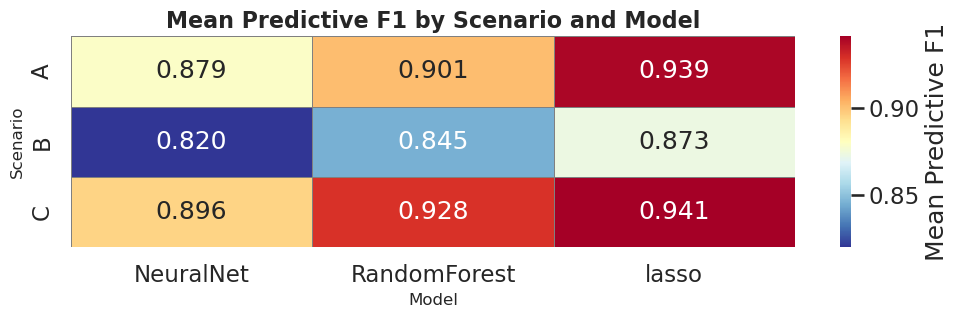

In [2]:
import pandas as pd, ast, textwrap
import matplotlib.pyplot as plt, seaborn as sns

import matplotlib as mpl
# Ensure we get DejaVu Sans (ships with matplotlib & covers most unicode):
mpl.rcParams['font.family'] = 'DejaVu Sans'
# You can also explicitly set:
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']

sns.set_context("talk")

# -------------------------------
# 0) Methoden ausschließen - HIER ÄNDERN!
# -------------------------------
# Definiere hier die Methoden, die du aus den Plots ausschließen möchtest
excluded_methods = { 'nimo_baseline', 'nimoNew', 'NeuralNet2', 'nimo_variant', 'lassonet'}  # Beispiel: randomForest und nimoNew ausschließen
# excluded_methods = set()  # Leeres Set = alle Methoden anzeigen

# -------------------------------
# 1) Daten einlesen & vorbereiten
# -------------------------------
df = pd.read_csv('../../results/synthetic/all_model_results_synthetic_20Iterations_JULY_NEW.csv')
#df = pd.read_csv('../results/synthetic/all_model_results_synthetic_20Iterations_JULY.csv')
df = df[df['error'].isna()] if 'error' in df else df
df['selected_features'] = df['selected_features'].fillna('[]')\
    .apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else [])
df['n_selected'] = df['selected_features'].apply(len)
for c in ['best_f1','n_selected','n_true_features']:
    if c in df: df[c] = pd.to_numeric(df[c], errors='coerce')

short_map = df.groupby('scenario')['scenario_short'].first().to_dict()
long_map  = df.groupby('scenario')['scenario_long'].first().to_dict()
scenarios = sorted(df['scenario'].unique())

# Methoden filtern - AUSSCHLUSS HIER ANWENDEN
all_methods = sorted(df['model_name'].unique())
methods = [m for m in all_methods if m not in excluded_methods]

print(f"Alle verfügbaren Methoden: {all_methods}")
print(f"Ausgeschlossene Methoden: {excluded_methods}")
print(f"Verwendete Methoden: {methods}")

palette   = dict(zip(methods, sns.color_palette("tab10", len(methods))))
linestyles = ['-','--','-.',':',(0,(5,1))]
markers    = ['o','s','D','^','v']
total_features = df['n_features_total'].iloc[0]

for scen in scenarios:
    grp = df[df['scenario']==scen]
    desc_s = short_map[scen]
    desc_l = long_map.get(scen,'')

    # pick each model's best‐f1 row
    best = grp.sort_values('best_f1', ascending=False).drop_duplicates('model_name')
    cm = []
    for m in methods:
        row = best[best['model_name']==m].iloc[0]
        S = {int(f.split('_')[-1]) for f in row['selected_features']}
        T = set(ast.literal_eval(row['true_support'])) if isinstance(row['true_support'], str) else set(row['true_support'])
        TP=len(S&T); FP=len(S-T); FN=len(T-S); TN=total_features-len(S|T)
        cm.append((m,TP,FP,FN,TN))
    cm_df = pd.DataFrame(cm, columns=['model','TP','FP','FN','TN']).set_index('model')

    # --- layout ---
    fig = plt.figure(figsize=(14,10))
    gs  = fig.add_gridspec(3,2,
        height_ratios=[0.4, 6, 1.5],
        width_ratios =[3, 2],
        hspace=0.8, wspace=0.3
    )

    fig.subplots_adjust(bottom=0.05)

    # title & subtitle row (spans both cols)
    axT = fig.add_subplot(gs[0,:])
    axT.axis('off')
    axT.text(0.5,1, scen + ": "+ desc_s, fontsize=20, fontweight='bold', ha='center')
    axT.text(0.5,0, "\n".join(textwrap.wrap(desc_l, 60)),
             fontsize=12, style='italic', ha='center')

    # F1 plot
    ax1 = fig.add_subplot(gs[1,0])
    for i,m in enumerate(methods):
        sub=grp[grp['model_name']==m]
        ax1.plot(sub['iteration'],sub['best_f1'],
                 color=palette[m],
                 linestyle=linestyles[i%len(linestyles)],
                 marker=markers[i%len(markers)],
                 label=m)
    ax1.set_title("Best F1 over Iterations"); ax1.set_xlabel("Iter"); ax1.set_ylabel("F1")
    ax1.grid(alpha=0.3)

    # selected count
    ax2 = fig.add_subplot(gs[1,1])
    for i,m in enumerate(methods):
        sub=grp[grp['model_name']==m]
        ax2.plot(sub['iteration'],sub['n_selected'],
                 color=palette[m],
                 linestyle=linestyles[i%len(linestyles)],
                 marker=markers[i%len(markers)])
    ax2.axhline(grp['n_true_features'].iloc[0],ls='--',color='gray',label='True support')
    ax2.set_title("Selected Features"); ax2.set_xlabel("Iter"); ax2.set_ylabel("Count")
    ax2.grid(alpha=0.3)

    # legend
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title="Model",
               bbox_to_anchor=(0.93,0.65), loc='center left', frameon=False)

    # confusion table
    ax3 = fig.add_subplot(gs[2,:])
    ax3.axis('off')
    tbl = ax3.table(cellText=cm_df.values,
                    rowLabels=cm_df.index,
                    colLabels=cm_df.columns,
                    cellLoc='center', loc='center')
    tbl.scale(1, 1.2)        # weniger vertikaler Stretch
    tbl.auto_set_font_size(True)
    tbl.set_fontsize(10)     # etwas kleinere Schrift

    plt.show()
# -------------------------------
# 3) Average F1 Barplot (Matplotlib)
# -------------------------------
# Nur die gefilterten Methoden für den Durchschnitt verwenden
avg_f1 = df[df['model_name'].isin(methods)].groupby('model_name')['best_f1'].mean().sort_values()

plt.figure(figsize=(8, 6))
colors = [palette[m] for m in avg_f1.index]
plt.barh(avg_f1.index, avg_f1.values, color=colors)
for i, (val, lab) in enumerate(zip(avg_f1.values, avg_f1.index)):
    plt.text(val + 0.01, i, f"{val:.3f}", va='center')
plt.title("Average Predictive F1 Across All Scenarios", fontsize=16, fontweight='bold')
plt.xlabel("Mean best_f1", fontsize=12)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# -------------------------------
# 4) Predictive F1 Heatmap (Mean best_f1)
# -------------------------------
# Nur die gefilterten Methoden für die Heatmap verwenden
heat_df = df[df['model_name'].isin(methods)].pivot_table(
    index='scenario', columns='model_name', values='best_f1', aggfunc='mean'
)
n_scen     = heat_df.shape[0]
fig_height = max(4, n_scen * 0.8)

fig, ax = plt.subplots(figsize=(12, fig_height))
vmin, vmax = heat_df.values.min(), heat_df.values.max()
sns.heatmap(
    heat_df, annot=True, fmt=".3f",
    cmap="RdYlBu_r", vmin=vmin, vmax=vmax,
    cbar_kws={'label': 'Mean Predictive F1'},
    linewidths=0.5, linecolor='gray', ax=ax
)
ax.set_title("Mean Predictive F1 by Scenario and Model", fontsize=16, fontweight='bold')
ax.set_ylabel("Scenario", fontsize=12)
ax.set_xlabel("Model", fontsize=12)

fig.tight_layout(rect=(0, 0, 0.85, 0.88))
plt.show()